# Power AutoCorrelation Strategy

This model is based on the German power auto-correlation strategy proposed by [Narro, J., and M. Caamano. Systematic Trading in Energy Markets. London, UK: Risk Books, 2020.]
Adding the constraint of long only, an end-of-day buy signal is generated using a simple rule: If the difference in price from yesterday’s close to today’s is positive,then go long at today’s close, else exit the position.
$$y_{t} = 
\begin{cases}
1, & \quad \text{if $\Delta r_{t} > 0$}\\
y_{t-1}, & \quad \text{if $\Delta r_{t} = 0$}\\
0, & \quad \text{if $\Delta r_{t} < 0$}
\end{cases} 
$$
where $y_{t}$ is the side of position, $y_{t} \in {0, 1}$, and $\Delta r_{t}$ is the difference in returns between  $r_{t} - r_{t-1}$.

[Jacques Francois Joubert, Meta-Labeling: Theory and  Framework, 2022]


In [1]:
from datetime import datetime

from hg_oap.dates.calendar import WeekendCalendar
from hg_oap.dates.date_services import business_days, business_days_from_calendar
from hgraph import register_service, default_path, lag, if_then_else, feedback, TS, drop_dups, sample, sum_
from hgraph.notebook import start_wiring_graph

from hg_systematic.data.generators import auto_regressive_generator

/Users/hhenson/PycharmProjects/hg_systematic/src/hg_systematic/data/generators.py:54: SyntaxWarning: invalid escape sequence '\p'
  """


In [2]:
start_wiring_graph("power_autocorrelation_strategy", start_time=datetime(2000, 1, 1), end_time=datetime(2024, 1, 1))
register_service(default_path, business_days_from_calendar, calendar_tp=WeekendCalendar)

In [3]:
dt = business_days()

In [4]:
returns = auto_regressive_generator(dt, order=1, initial_values=(0.0,), 
                                             coefficients=(0.0, 0.1), centre=0.0, std_dev=0.000211, size=300*24)

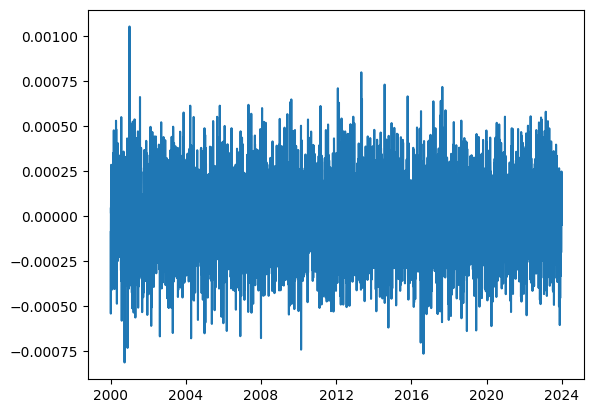

In [5]:
returns.plot()

Since we are running off of a signal for generating returns, we can use a tick-by-tick lag (of 1) to get the previous return.
Next for the signal, we want to split this into three cases, where one of the cases result depends on the previous state of the signal.
We track the previous value by using a ``feedback`` to return the last value of the signal to ourselves. This will tick the value of the signal
one ``MIN_TD`` or in this case 1 micro-second later (the smallest time-delta for an engine cycle).
We can then lag the signal by 1 to ensure we get the previous result. 

    This does create a small problem in that the previous signal (if selected) will tick again in 1 mirco seconds time. (The ``drop_dups`` helps clean this up)

The conditional logic is split into two ``if_then_else`` clauses. To reduce computation, we perform a ``drop_dups`` to only tick the feedback (and related logic)
if the value of the signal changes.

Finally, to ensure that we get a tick of signal value for each day we are computing it for, we sample the signal value using the ``dt`` at a timer.

In [6]:
delta_r = returns - lag(returns, period=1)
fb = feedback(TS[float], 0.0)  # To support the previous signal value as an input to the condition.
signal_prev = lag(fb(), period=1)
signal = drop_dups(if_then_else(delta_r == 0.0, signal_prev, if_then_else(delta_r > 0.0, 1.0, 0.0)))
fb(signal)
signal = sample(dt, signal)

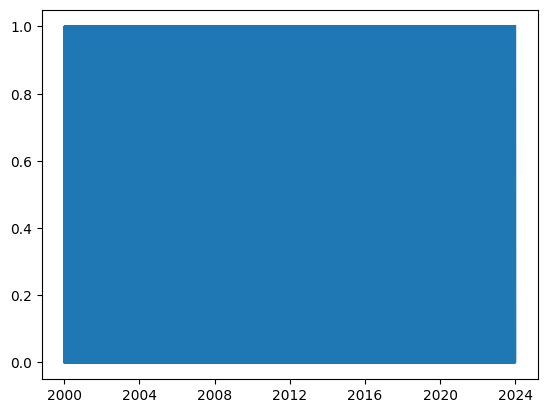

In [7]:
signal.plot()

To compute a pseudo pnl we assume the signal equates to holding a position in the instrument associated with the return. We then gain the return by holding the position for a business day. Thus, yesterday's signal multiplied by today's return gives us the return we earned today. We then sum the pnl from inception until now to get the cumulative pnl for the strategy. 

In [8]:
pnl = lag(signal, period=1) * returns  # Yesterday's signal * today's return = pnl
cum_pnl = sum_(pnl)

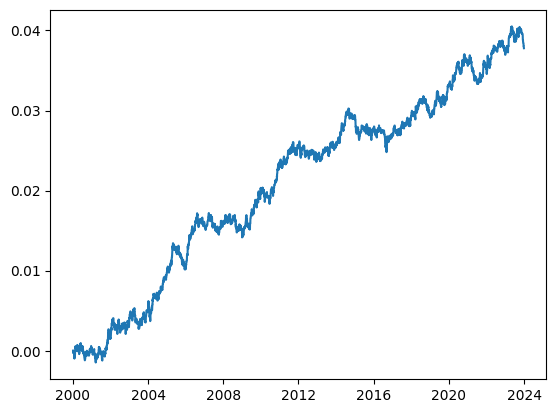

In [9]:
cum_pnl.plot()